# Predicting next ingredient

In out task of predicting the next ingredient, given previous ingredients, we are motivated from the NLP task of next word prediction. Auto-completion or suggesting next words are common applications of language prediction.
There are generally two approaches used in next word prediction.
1. The conventional approach is using n-gram models. 
2. A better approach is using LSTM (Long Short Term Memory) 

With the n-gram approach, we predict the most probable following word from the training data, given n previous words. Based on the number of sequence words that we look at, there are bi-gram, 3-gram, 4-gram models...
For instance, if we have <i>wheat_flour almond_mild oats baking_powder salt</i> and we are considering a bigram model, then predicting next ingredient, eg. <i>egg</i>, depends on how many times <i>salt egg</i> appeared in the training corpus. One big limitation of such models is that they are simply based on frequencies of the n-grams.  

A more advanced approach, using a neural language model, is to use <b>Long Short Term Memory (LSTM)</b>.
LSTM is type of an RNN, which is used for sequential data, like text and series. LSTM models use deep learning and some 'special' cells to manage memory, which comes as an improvement on top os standard RNN models.

In this notebook we build and train a 3 layers LSTM, in an attempt to predict next ingredient in a recipe, given 5 previous ingredients. We also look at <b>Word2vec</b>, an approach for learning dense word representations. 
The task then would be to see the benefit of using dense representations, instead of one-hot encoding as input to the LSTM. 



### IMPORTS

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pickle

import heapq

Using TensorFlow backend.


### Load Cleaned Data

In [2]:
recipe_ingredients = pd.read_pickle('processed_ingridients.pkl')
recipe_ingredients_df = pd.DataFrame(recipe_ingredients)
recipe_ingredients_df.head()

recipe_ingredients  \
000018c8a5  [penne, cheese, sauce, cheese, chili_powder, b...   
000033e39b  [macaroni, cheese, celery, green, pepper, pime...   
000035f7ed  [tomatoes, salt, red_onion, green, bell_pepper...   
00003a70b1  [milk, water, butter, mashed_potatoes, corn, c...   
00004320bb  [watermelon, gelatin, boiling_water, cool_whip...   

                                         title  
000018c8a5          Worlds Best Mac and Cheese  
000033e39b         Dilly Macaroni Salad Recipe  
000035f7ed                            Gazpacho  
00003a70b1           Crunchy Onion Potato Bake  
00004320bb  Cool 'n Easy Creamy Watermelon Pie

In [3]:
#Remove recipes with less than three inredients
recipe_ingredients_lst = []
for item in recipe_ingredients_df.recipe_ingredients:
  if len(item)>=3:
    recipe_ingredients_lst.append(list(set(item)))

In [4]:
#static function
flatten = lambda l: [item for sublist in l for item in sublist]

In [5]:
ingredients = flatten(recipe_ingredients_lst)

In [6]:
unique_ingredients = np.unique(ingredients)

In [7]:
unique_ingredients[:100]

array(['abalone', 'achiote', 'acid', 'acorn', 'adzuki_bean', 'agar',
       'alaska_pollock', 'albacore', 'alchermes', 'alkali', 'allspice',
       'almond', 'almonds', 'amaranth', 'amaretto', 'anchovies',
       'anchovy', 'animal_fat', 'anise', 'aniseed', 'annatto', 'apple',
       'apricot', 'arepa', 'arrowroot', 'artichoke',
       'artificial_sweetener', 'arugula', 'asparagus', 'atsuete',
       'au_jus', 'aubergine', 'avocado', 'azuki', 'azuki_bean_paste',
       'back_bacon', 'bacon', 'bagel', 'baguette', 'baked_beans',
       'bakers_yeast', 'baking_powder', 'baking_soda', 'bamboo', 'banana',
       'bananas', 'barbecue_sauce', 'barley', 'barley_malt_syrup', 'barm',
       'basil', 'basmati', 'basmati_rice', 'bat', 'bay_leaf',
       'bay_leaves', 'bean', 'bean_curd', 'beancurd', 'beans', 'bechamel',
       'bee_hoon', 'beef', 'beefsteak', 'beer', 'beeswax', 'beet',
       'beet_root', 'beetroot', 'belachan', 'bell_pepper', 'bell_peppers',
       'bengal_gram', 'beni_shoga', 'b

In [8]:
len(unique_ingredients)


1088

### Feature Engineering

1. Assign a number to each distinct ingredient
2. Build one-hot encodings for each sequence of ingredients that will be used as input in the LSTM model

In [9]:
#Assign an index to each unique ingredient
unique_ingredient_index = dict((c, i) for i, c in enumerate(unique_ingredients))

In [10]:
unique_ingredient_index

{'abalone': 0,
 'achiote': 1,
 'acid': 2,
 'acorn': 3,
 'adzuki_bean': 4,
 'agar': 5,
 'alaska_pollock': 6,
 'albacore': 7,
 'alchermes': 8,
 'alkali': 9,
 'allspice': 10,
 'almond': 11,
 'almonds': 12,
 'amaranth': 13,
 'amaretto': 14,
 'anchovies': 15,
 'anchovy': 16,
 'animal_fat': 17,
 'anise': 18,
 'aniseed': 19,
 'annatto': 20,
 'apple': 21,
 'apricot': 22,
 'arepa': 23,
 'arrowroot': 24,
 'artichoke': 25,
 'artificial_sweetener': 26,
 'arugula': 27,
 'asparagus': 28,
 'atsuete': 29,
 'au_jus': 30,
 'aubergine': 31,
 'avocado': 32,
 'azuki': 33,
 'azuki_bean_paste': 34,
 'back_bacon': 35,
 'bacon': 36,
 'bagel': 37,
 'baguette': 38,
 'baked_beans': 39,
 'bakers_yeast': 40,
 'baking_powder': 41,
 'baking_soda': 42,
 'bamboo': 43,
 'banana': 44,
 'bananas': 45,
 'barbecue_sauce': 46,
 'barley': 47,
 'barley_malt_syrup': 48,
 'barm': 49,
 'basil': 50,
 'basmati': 51,
 'basmati_rice': 52,
 'bat': 53,
 'bay_leaf': 54,
 'bay_leaves': 55,
 'bean': 56,
 'bean_curd': 57,
 'beancurd': 58,


In [11]:
#Walk a window of length 5 through the lists of ingredients. The generated sequences of length 5 will be used as input in the LSTM

SEQ_LENGTH = 5
prev_ingredients = []
next_ingredient = []
for i in range(len(ingredients) - SEQ_LENGTH):
    prev_ingredients.append(ingredients[i:i + SEQ_LENGTH])
    next_ingredient.append(ingredients[i + SEQ_LENGTH])
print(prev_ingredients[:10])
print(next_ingredient[:10])

[['sauce', 'cheese', 'salt', 'butter', 'chili_powder'], ['cheese', 'salt', 'butter', 'chili_powder', 'garlic'], ['salt', 'butter', 'chili_powder', 'garlic', 'flour'], ['butter', 'chili_powder', 'garlic', 'flour', 'penne'], ['chili_powder', 'garlic', 'flour', 'penne', 'milk'], ['garlic', 'flour', 'penne', 'milk', 'pimento'], ['flour', 'penne', 'milk', 'pimento', 'cheese'], ['penne', 'milk', 'pimento', 'cheese', 'dill'], ['milk', 'pimento', 'cheese', 'dill', 'salt'], ['pimento', 'cheese', 'dill', 'salt', 'pepper']]
['garlic', 'flour', 'penne', 'milk', 'pimento', 'cheese', 'dill', 'salt', 'pepper', 'green']


In [12]:
#Save 10% of the data for testing
X, X_test, Y, y_test = train_test_split(prev_ingredients, next_ingredient, test_size=0.10, random_state=42)

In [13]:
len(X_test)

103130

In [14]:
#Derive one-hot encoding
X_train = np.zeros((len(X), SEQ_LENGTH, len(unique_ingredients)), dtype=bool)
Y_train = np.zeros((len(Y), len(unique_ingredients)), dtype=bool)
for i, each_words in enumerate(X):
    for j, each_word in enumerate(each_words):
        X_train[i, j, unique_ingredient_index[each_word]] = 1
    Y_train[i, unique_ingredient_index[Y[i]]] = 1

In [15]:
X_train.shape

(928164, 5, 1088)

In [16]:
Y_train.shape

(928164, 1088)

## Build LSTM

In [18]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQ_LENGTH, len(unique_ingredients))))
model.add(Dense(len(unique_ingredients)))
model.add(Activation('softmax'))

In [20]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_split=0.05, batch_size=128, epochs=3, shuffle=True).history

Train on 881755 samples, validate on 46409 samples
Epoch 1/3
881755/881755 [==============================] - 450s 510us/step - loss: 3.8487 - accuracy: 0.2355 - val_loss: 3.8175 - val_accuracy: 0.2423
Epoch 2/3
881755/881755 [==============================] - 472s 535us/step - loss: 3.7667 - accuracy: 0.2470 - val_loss: 3.7961 - val_accuracy: 0.2477
Epoch 3/3
881755/881755 [==============================] - 463s 525us/step - loss: 3.7497 - accuracy: 0.2514 - val_loss: 3.7955 - val_accuracy: 0.2478


In [21]:
model.save('last_keras_next_word_model.h5')
pickle.dump(history, open("last_history.p", "wb"))

In [22]:
model = load_model('last_keras_next_word_model.h5')
history = pickle.load(open("last_history.p", "rb"))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               623104    
_________________________________________________________________
dense_1 (Dense)              (None, 1088)              140352    
_________________________________________________________________
activation_1 (Activation)    (None, 1088)              0         
Total params: 763,456
Trainable params: 763,456
Non-trainable params: 0
_________________________________________________________________


In [24]:
history

{'val_loss': [3.8175369141474755, 3.7961207793132887, 3.7954740755266574],
 'val_accuracy': [0.24232368171215057,
  0.24768902361392975,
  0.24777521193027496],
 'loss': [3.8487349282502055, 3.766696877517705, 3.7497105375812496],
 'accuracy': [0.23548718, 0.24696656, 0.2513839]}

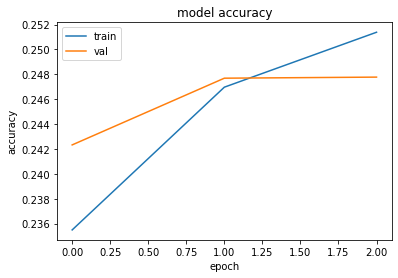

In [25]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

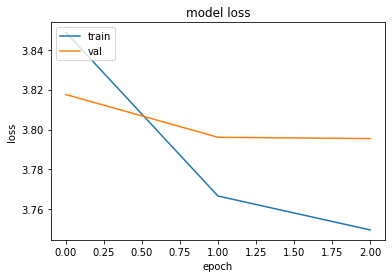

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

## Make Predictions

In [27]:
#Convert input ingredients the the required format required by the model
def prepare_input(input_ingredients):
    x = np.zeros((1, SEQ_LENGTH, len(unique_ingredients)))
    for t, ingredient in enumerate(input_ingredients):
        x[0, t, unique_ingredient_index[ingredient]] = 1
    return x
prepare_input(['sour_cream', 'milk', 'salt', 'butter', 'egg'])

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [28]:
#Have the reverse dictionary, as a lookup table to convert indices back to ingredients' names
index_unique_ingredient = {index: value for value, index in unique_ingredient_index.items()}

In [29]:
index_unique_ingredient

{0: 'abalone',
 1: 'achiote',
 2: 'acid',
 3: 'acorn',
 4: 'adzuki_bean',
 5: 'agar',
 6: 'alaska_pollock',
 7: 'albacore',
 8: 'alchermes',
 9: 'alkali',
 10: 'allspice',
 11: 'almond',
 12: 'almonds',
 13: 'amaranth',
 14: 'amaretto',
 15: 'anchovies',
 16: 'anchovy',
 17: 'animal_fat',
 18: 'anise',
 19: 'aniseed',
 20: 'annatto',
 21: 'apple',
 22: 'apricot',
 23: 'arepa',
 24: 'arrowroot',
 25: 'artichoke',
 26: 'artificial_sweetener',
 27: 'arugula',
 28: 'asparagus',
 29: 'atsuete',
 30: 'au_jus',
 31: 'aubergine',
 32: 'avocado',
 33: 'azuki',
 34: 'azuki_bean_paste',
 35: 'back_bacon',
 36: 'bacon',
 37: 'bagel',
 38: 'baguette',
 39: 'baked_beans',
 40: 'bakers_yeast',
 41: 'baking_powder',
 42: 'baking_soda',
 43: 'bamboo',
 44: 'banana',
 45: 'bananas',
 46: 'barbecue_sauce',
 47: 'barley',
 48: 'barley_malt_syrup',
 49: 'barm',
 50: 'basil',
 51: 'basmati',
 52: 'basmati_rice',
 53: 'bat',
 54: 'bay_leaf',
 55: 'bay_leaves',
 56: 'bean',
 57: 'bean_curd',
 58: 'beancurd',


In [30]:
def suggest_next_ingredient(input_ingredients, n=5):
    x = prepare_input(input_ingredients)
    preds = model.predict(x, verbose=0)[0]
    next_indices = heapq.nlargest(n, range(len(preds)), preds.take)
    return [index_unique_ingredient[idx] for idx in next_indices]

### Evaluate Model in Test Data

In [31]:
y_test

['cranberry',
 'almonds',
 'water',
 'oil',
 'food_coloring',
 'oil',
 'sausage',
 'egg',
 'rice',
 'cinnamon',
 'milk',
 'chile_powder',
 'white_wine',
 'black_pepper',
 'hollandaise_sauce',
 'liquid',
 'butter',
 'syrup',
 'margarine',
 'garlic',
 'spinach',
 'lemon',
 'ginger',
 'oil',
 'corn',
 'lemon',
 'flour',
 'salt',
 'sauce',
 'flour',
 'goat',
 'white_sugar',
 'olive',
 'juice',
 'lemon',
 'egg_yolks',
 'salt',
 'wine',
 'meat',
 'cheddar_cheese',
 'pudding',
 'green',
 'butter',
 'garlic',
 'carrots',
 'ginger',
 'liqueur',
 'onion',
 'garnish',
 'tomatoes',
 'onion',
 'vinegar',
 'beef',
 'oil',
 'cloves',
 'cloves',
 'chicken',
 'cream',
 'ice',
 'onion',
 'black_pepper',
 'brown_sugar',
 'shallot',
 'sour_cream',
 'chili_powder',
 'cooking_spray',
 'butter',
 'oil',
 'garlic',
 'honey',
 'sugar',
 'provolone',
 'bacon',
 'beans',
 'ginger',
 'bell_peppers',
 'cream',
 'garlic',
 'brown_sugar',
 'tapioca',
 'oregano',
 'jicama',
 'chicken',
 'salt',
 'mushrooms',
 'baking

In [32]:
y_preds = []
for test_ingredients in X_test:
    y_preds.append(suggest_next_ingredient(test_ingredients))
        

In [33]:
y_preds

[['cloves', 'green', 'red_pepper', 'carrots', 'paprika'],
 ['olive', 'extract', 'cream', 'sauce', 'sweet'],
 ['water', 'butter', 'yeast', 'pepper', 'white_sugar'],
 ['oil', 'juice', 'beef', 'eggs', 'thyme'],
 ['eggs', 'cheese', 'granulated_sugar', 'salt', 'vegetable_oil'],
 ['oil', 'eggs', 'juice', 'shallots', 'feta'],
 ['cloves', 'paprika', 'green', 'oregano', 'soup'],
 ['pepper', 'garlic', 'egg', 'water', 'onions'],
 ['pepper', 'water', 'butter', 'ginger', 'rice'],
 ['cinnamon', 'pineapple', 'cornstarch', 'oats', 'egg'],
 ['olives', 'black_pepper', 'celery', 'parsley', 'beans'],
 ['flour', 'tomatoes', 'butter', 'green', 'chocolate'],
 ['garlic', 'parsley', 'flour', 'lemon', 'white_wine'],
 ['cumin', 'black_pepper', 'beans', 'olives', 'green'],
 ['cheese', 'sour_cream', 'mozzarella', 'hot_pepper', 'cheddar_cheese'],
 ['black_pepper', 'sugar', 'chicken', 'vinegar', 'brown_sugar'],
 ['garlic', 'tomatoes', 'pepper', 'onions', 'butter'],
 ['flour', 'egg', 'heavy_cream', 'powdered_sugar', 

In [36]:
def calc_precision(y_preds, y_test):
    positives = 0
    negatives = 0
    for next_ing, preds in zip(y_test, y_preds):
        if next_ing in preds:
            positives += 1
        else:
            negatives += 1
    return positives/(positives + negatives)

calc_precision(y_preds, y_test)

0.5079414331426355

# Word2Vec: Dense Word Representations

In [ ]:
import random
import pandas as pd
import numpy as np
import gensim
from gensim.models import KeyedVectors, Word2Vec

In [ ]:
recipe_ingredients = pd.read_pickle('processed_ingridients.pkl')
recipe_ingredients_df = pd.DataFrame(recipe_ingredients)
recipe_ingredients_df.head()

In [ ]:
#Convert recipe_ingredients to list of lists: the required input to Word2Vec
recipe_ingredients_lst = []
for item in recipe_ingredients_df.recipe_ingredients:
  if len(item)>=3:
    recipe_ingredients_lst.append(list(set(item)))

In [ ]:
#Train word2vec model 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model_ing2vec = Word2Vec(size=300, min_count=5, window=10, sg=1, negative=5)
model_ing2vec.build_vocab(sentences = recipe_ingredients_lst)
total_examples = model_ing2vec.corpus_count

model_ing2vec.train(sentences = recipe_ingredients_lst, total_examples=total_examples, epochs=10)
model_ing2vec.save('ing2vec_ingredients.bin')

In [ ]:
#Load trained model
ing2vec_path_wo_pretrained = 'ing2vec_ingredients.bin'
model_ing2vec_wo_pretrained = Word2Vec.load(ing2vec_path_wo_pretrained)
print(model_ing2vec_wo_pretrained)

In [ ]:
print(model_ing2vec.wv.most_similar(['milk'], topn=5))

In [ ]:
print(model_ing2vec.wv.most_similar(['ground_beef'], topn=5))

In [ ]:
print(model_ing2vec.wv.most_similar(['cheddar_cheese'], topn=5))

In [ ]:
word2vec_preds = []
for test_ingredients in X_test:
    preds = model_ing2vec.predict_output_word(context_words_list=test_ingredients, topn=5)
    pred_ingredients = [pred[0] for pred in preds]
    word2vec_preds.append(pred_ingredients)

In [ ]:
calc_presicion(word2vec_preds, y_test)